## Imports

In [1]:
%run -n train.py

In [2]:
%run utils.py

In [3]:
%run utilsT.py

In [4]:
device = get_torch_device()
device

device(type='cuda')

## Params

In [5]:
# In server
BASE_DIR = '/mnt/data/chest-x-ray-8'
DATASET_DIR = BASE_DIR + "/dataset"
CMS_DIR = BASE_DIR + "/cms"

In [6]:
TRAIN_RESNET = False
N_EPOCHS = 1
BATCH_SIZE = 4
FLUSH_SECS = 10 # Use a low value when debugging

# Use None to unset the maximum
train_max_images = 100 # None
val_max_images = 100 # None # 2000 # None

In [7]:
learning_rate = 1e-6
optimizer_moment = 0.9
weight_decay = 0
regularization = 0

In [8]:
chosen_diseases = list(ALL_DISEASES)
chosen_diseases

['Atelectasis',
 'Cardiomegaly',
 'Effusion',
 'Infiltration',
 'Mass',
 'Nodule',
 'Pneumonia',
 'Pneumothorax',
 'Consolidation',
 'Edema',
 'Emphysema',
 'Fibrosis',
 'Pleural_Thickening',
 'Hernia']

## Train

In [21]:
model_run = train_model(base_dir=BASE_DIR,
                        chosen_diseases=chosen_diseases,
                        n_epochs=N_EPOCHS,
                        batch_size=BATCH_SIZE,
                        lr=learning_rate,
                        moment=optimizer_moment,
                        decay=weight_decay,
                        reg=regularization,
                        train_resnet=TRAIN_RESNET,
                        image_format="RGB",
                        flush_secs=FLUSH_SECS,
                        train_max_images=train_max_images,
                        val_max_images=val_max_images,
                        experiment_mode="debug",
                        save=False,
                        write_graph=False,
                        write_emb=True,
                        write_emb_img=False,
                       )

Using device:  cuda
Loading train dataset...
Loading val dataset...
Run name:  2019-10-23_15-46-02_all
Saved TB in:  /mnt/data/chest-x-ray-8/runs/debug/2019-10-23_15-46-02_all
--------------------------------------------------
Training...
Finished epoch 1/1, loss 81.20822143554688 (val 83.4623031616211)
Average time per epoch:  0h 0m 5s


In [71]:
model_run.run_name

'2019-10-23-14-18-34_all'

## Load model

In [9]:
run_name = "2019-10-23_15-58-07"

In [10]:
model, _, chosen_diseases = load_model(BASE_DIR, run_name)
model = model.to(device)

In [11]:
_ = model.train(False)

## Load data

In [12]:
%%time
dataset, dataloader = prepare_data(DATASET_DIR, "train", chosen_diseases, BATCH_SIZE, max_images=None)
n_images, n_diseases = dataset.size()
n_images, n_diseases

CPU times: user 1min 33s, sys: 456 ms, total: 1min 33s
Wall time: 1min 33s


(75714, 8)

## Plot confusion matrices

In [42]:
val_cms = np.load(CMS_DIR + "/" + run_name + "_val.npy") # train, val or all
val_cms.shape

(8, 2, 2)

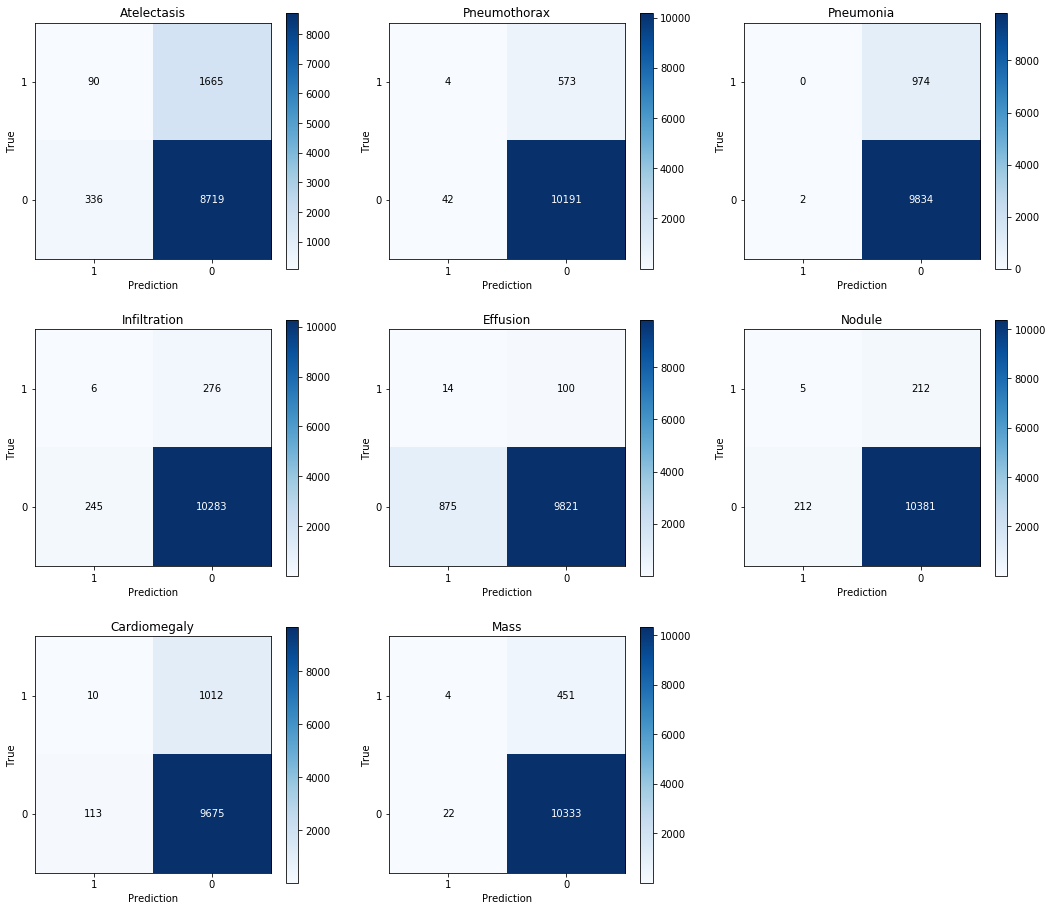

In [43]:
classes = [1, 0] # Positive, negative

plt.figure(figsize=(18,16))
plot_cms(cms, classes, chosen_diseases)

## Add images

In [186]:
def gen_image_with_bbox(image_name):
    bboxes_found = []
    bboxes_diseases = []

    image, _, _, bboxes_raw, are_valid = train_dataset.get_by_name(image_name)

    # Convert to batch
    images = image.view(1, *image.shape)

    # Image to GPU
    images = images.to(device)

    # Pass thru model
    _, _, activations = model(images)

    # Copy bbox
    for disease_index, (bbox, is_valid) in enumerate(zip(bboxes_raw, are_valid)):
        is_valid = bool(is_valid.item())
        disease_name = TRAINED_WITH_DISEASES[disease_index]
        if is_valid:
            bboxes_found.append(bbox)
            bboxes_diseases.append(disease_name)

    return image, bboxes_found, bboxes_diseases

In [202]:
image, bboxes_found, bboxes_diseases = gen_image_with_bbox("00000001_000.png")
image.size(), bboxes_found, bboxes_diseases

(torch.Size([3, 512, 512]), [], [])

In [181]:
writer.add_images("test-images-2", all_images[:10], global_step=N_EPOCHS)

## Plot activations

In [108]:
images, labels, _, _, _ = next(iter(train_dataloader))
images = images.to(device)
images.size()

torch.Size([4, 3, 512, 512])

In [109]:
pred, embedding, activation = model(images)
activation.size()

torch.Size([4, 1, 16, 16])

In [114]:
images = images.cpu()
activation = activation.cpu()

In [111]:
import matplotlib.pyplot as plt

Prediction:  0.0185812059789896
Label:  0


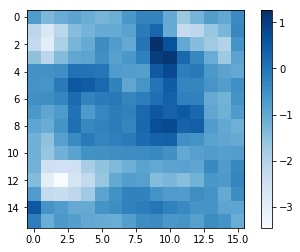

In [112]:
image_idx = 0

prediction = pred[image_idx].item()
label = labels[image_idx].item()

plt.imshow(activation[image_idx][0], cmap="Blues")
plt.colorbar()

print("Prediction: ", prediction)
print("Label: ", label)

In [116]:
images.size()

torch.Size([4, 3, 512, 512])

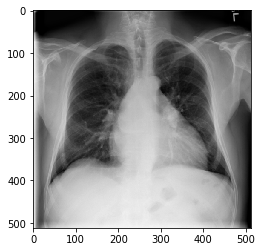

In [126]:
plt.imshow(images[image_idx][0], cmap="gray")

***
***

# Old

In [27]:
# FIXME: this code is to calculate the loss of the bbox prediction,
# though the metric should be different? don't use binary cross entropy?

#     # Get valid bbox_list
#     # REVIEW: make bbox_list a tensor? and then send to device? same on seg_list below
#     bbox_list = []
#     n_samples, n_labels = bbox_valids.size()
#     for i in range(n_samples):
#         bbox_list.append([])
#         for j in range(n_labels):
#             if bbox_valids[i][j] == 1:
#                 bbox_list[i].append(bboxes[i][j])
#         bbox_list[i] = torch.stack(bbox_list[i]).to(device)
    
    
#     # Segmentation lists
#     seg_list = []
#     for i in range(n_samples):
#         seg_list.append([])
#         for j in range(n_labels):
#             if bbox_valids[i][j] == 1:
#                 seg_list[i].append(segments[i][j])
#         seg_list[i] = torch.stack(seg_list[i]).to(device)
    
#     # Compute bbox loss
#     for i in range(len(seg_list)):
#         # REVIEW: do this with a tensor? avoid the loop
#         loss += 5/(512*512) * weighted_cross_entropy(seg_list[i], bbox_list[i], weights=(10, 1))
        
#         break
# #         print(seg_list[i].size())
# #         print(bbox_list[i].size())
# #         break